In [1]:
import cv2 as cv
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d, convolve2d

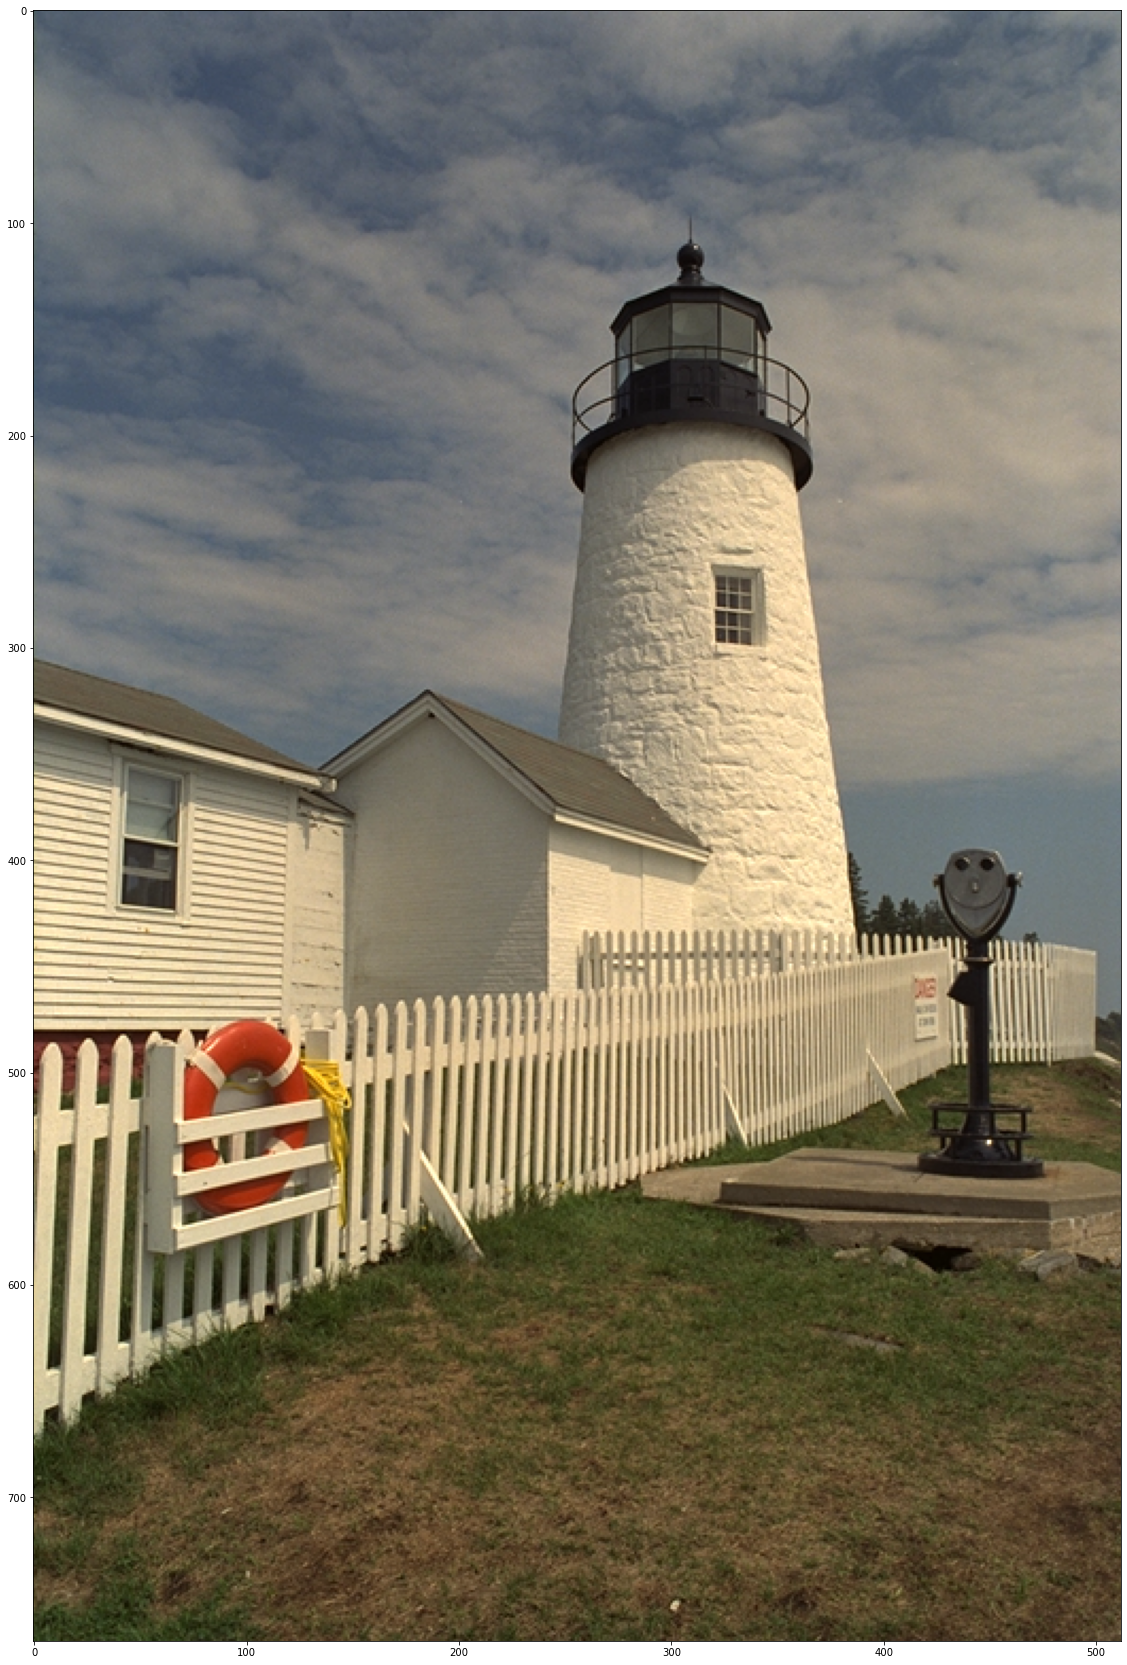

In [2]:
color = cv.imread('Kodak/kodim19.png', -1)
color = cv.cvtColor(color, cv.COLOR_BGR2RGB)

plt.figure(figsize=(20, 30))
plt.imshow(color)

# Generate Bayer RAW Image from Color Image
### Note: Assume we're in linear RGB space

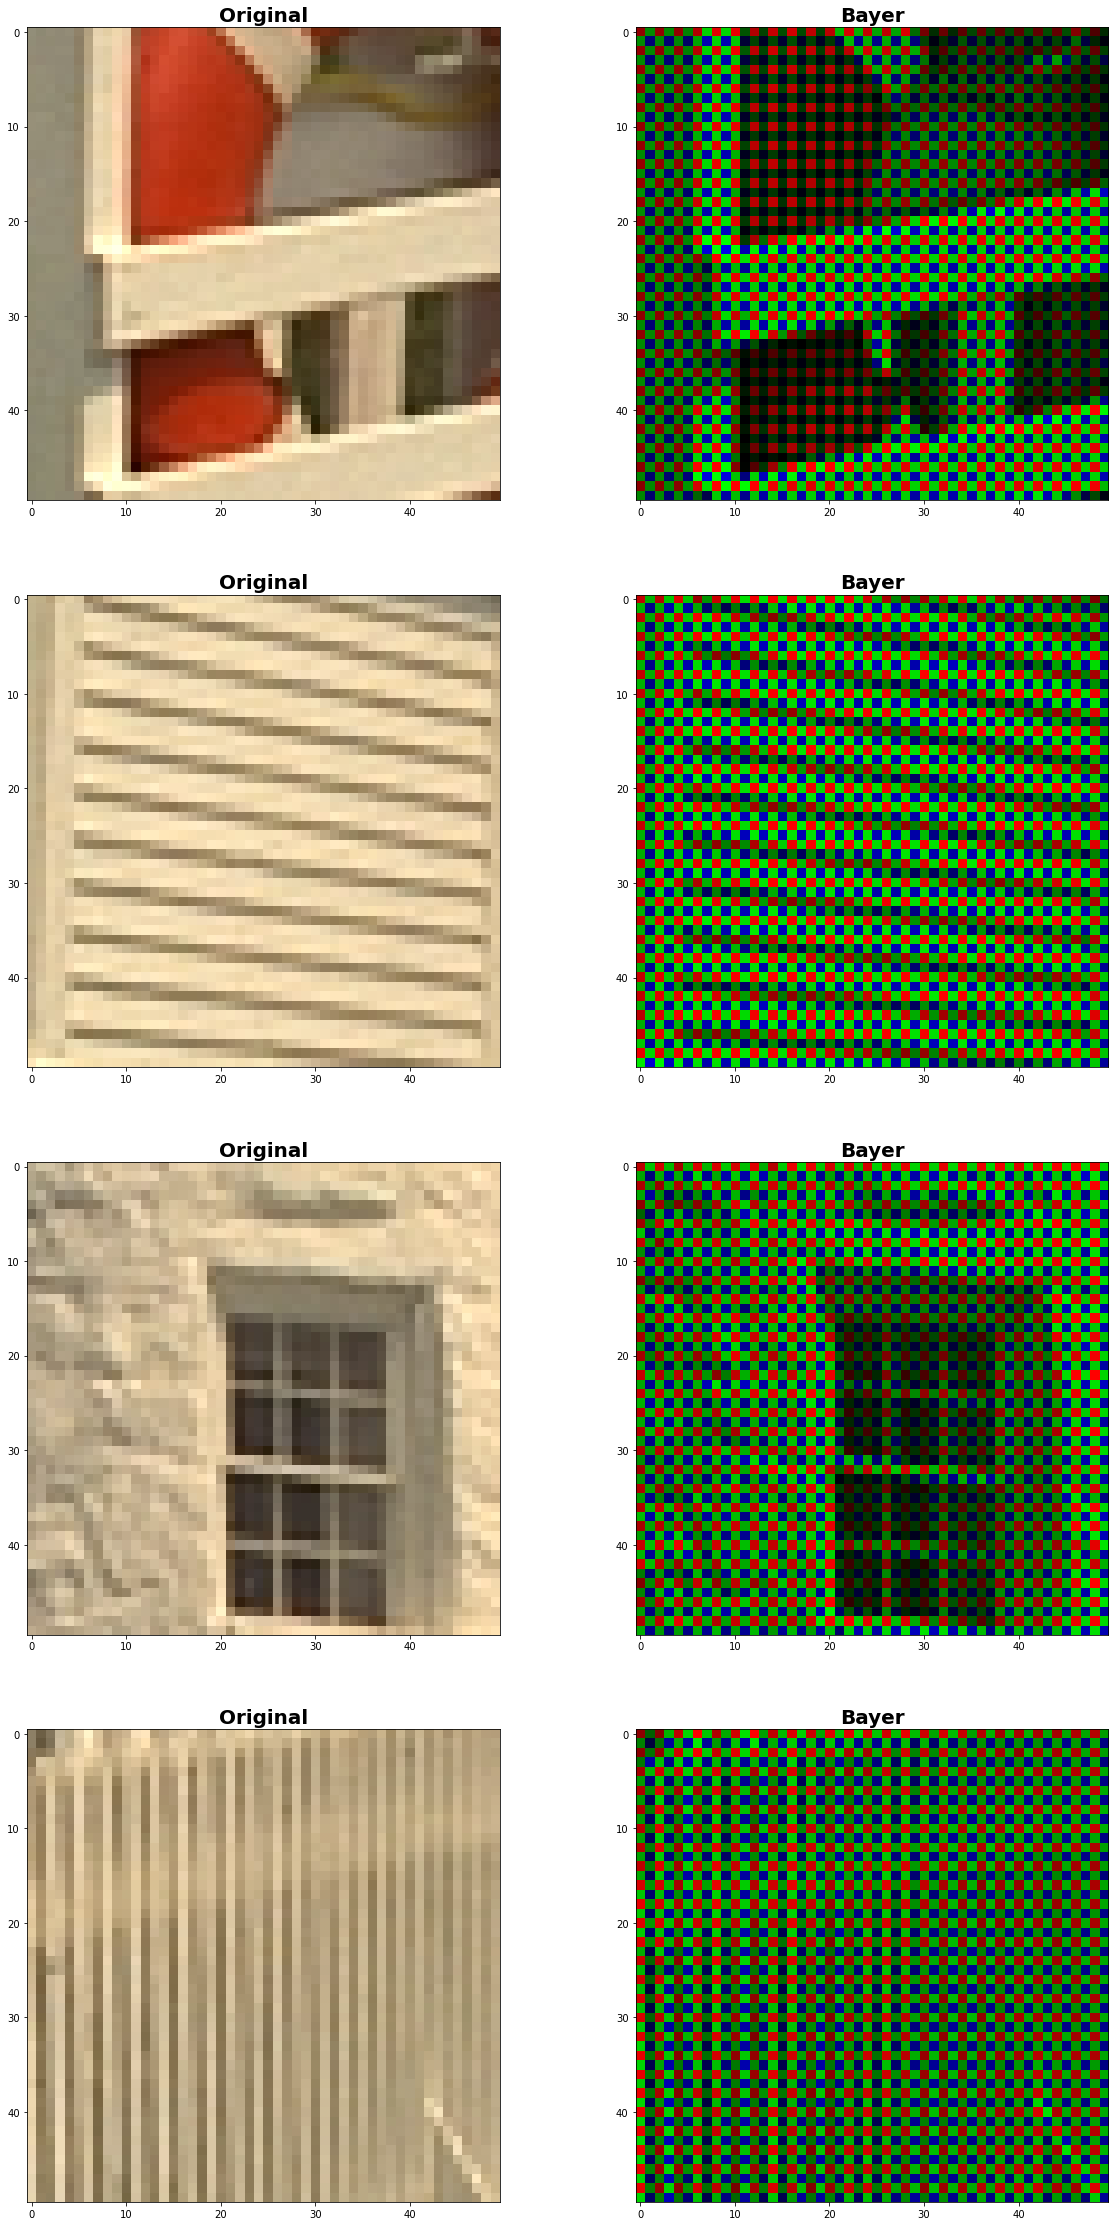

In [3]:
Rcfa = np.tile(np.array([[True, False], [False, False]]), (color.shape[0]//2, color.shape[1]//2))
GRcfa = np.tile(np.array([[False, True], [False, False]]), (color.shape[0]//2, color.shape[1]//2))
GBcfa = np.tile(np.array([[False, False], [True, False]]), (color.shape[0]//2, color.shape[1]//2))
Gcfa = GRcfa + GBcfa
Bcfa = np.tile(np.array([[False, False], [False, True]]), (color.shape[0]//2, color.shape[1]//2))
R = Rcfa * color[:,:,0]
G = Gcfa * color[:,:,1]
B = Bcfa * color[:,:,2]

bayer = R + G + B
bayer3c = np.stack((R, G, B), axis=-1)

with open('bayer8.pgm', 'wb') as f:
    f.write(bytes('P5\n', 'ascii'))
    f.write(bytes('512 768\n', 'ascii'))
    f.write(bytes('255\n', 'ascii'))
    f.write(bayer)
    f.close()

R = R/255
G = G/255
B = B/255
    
def pltCompare(imlist, namelist=None):
    regions = [(500, 550, 60, 110),
               (380, 430, 70, 120),
               (250, 300, 300, 350),
               (450, 500, 350, 400)]
    cols = len(imlist)
    rows = len(regions)
    
    plt.figure(figsize=(10*cols, 10*rows))
    for i in range(rows):
        reg = regions[i]
        for j in range(cols):
            im = imlist[j]
            fig = plt.subplot(rows, cols, cols*i+j+1)
            fig.imshow(im[reg[0]:reg[1], reg[2]:reg[3]])
            if namelist != None:
                name = namelist[j]
                ax = plt.gca()
                ax.set_title(name, fontweight="bold", size=20)
            
pltCompare([color, bayer3c], ['Original', 'Bayer'])

# Bilinear Interpolation    


### <img src="bilinear.png" alt="isolated" width="400"/>
### Same result with OpenCV. Massive zipper effect and false color

True

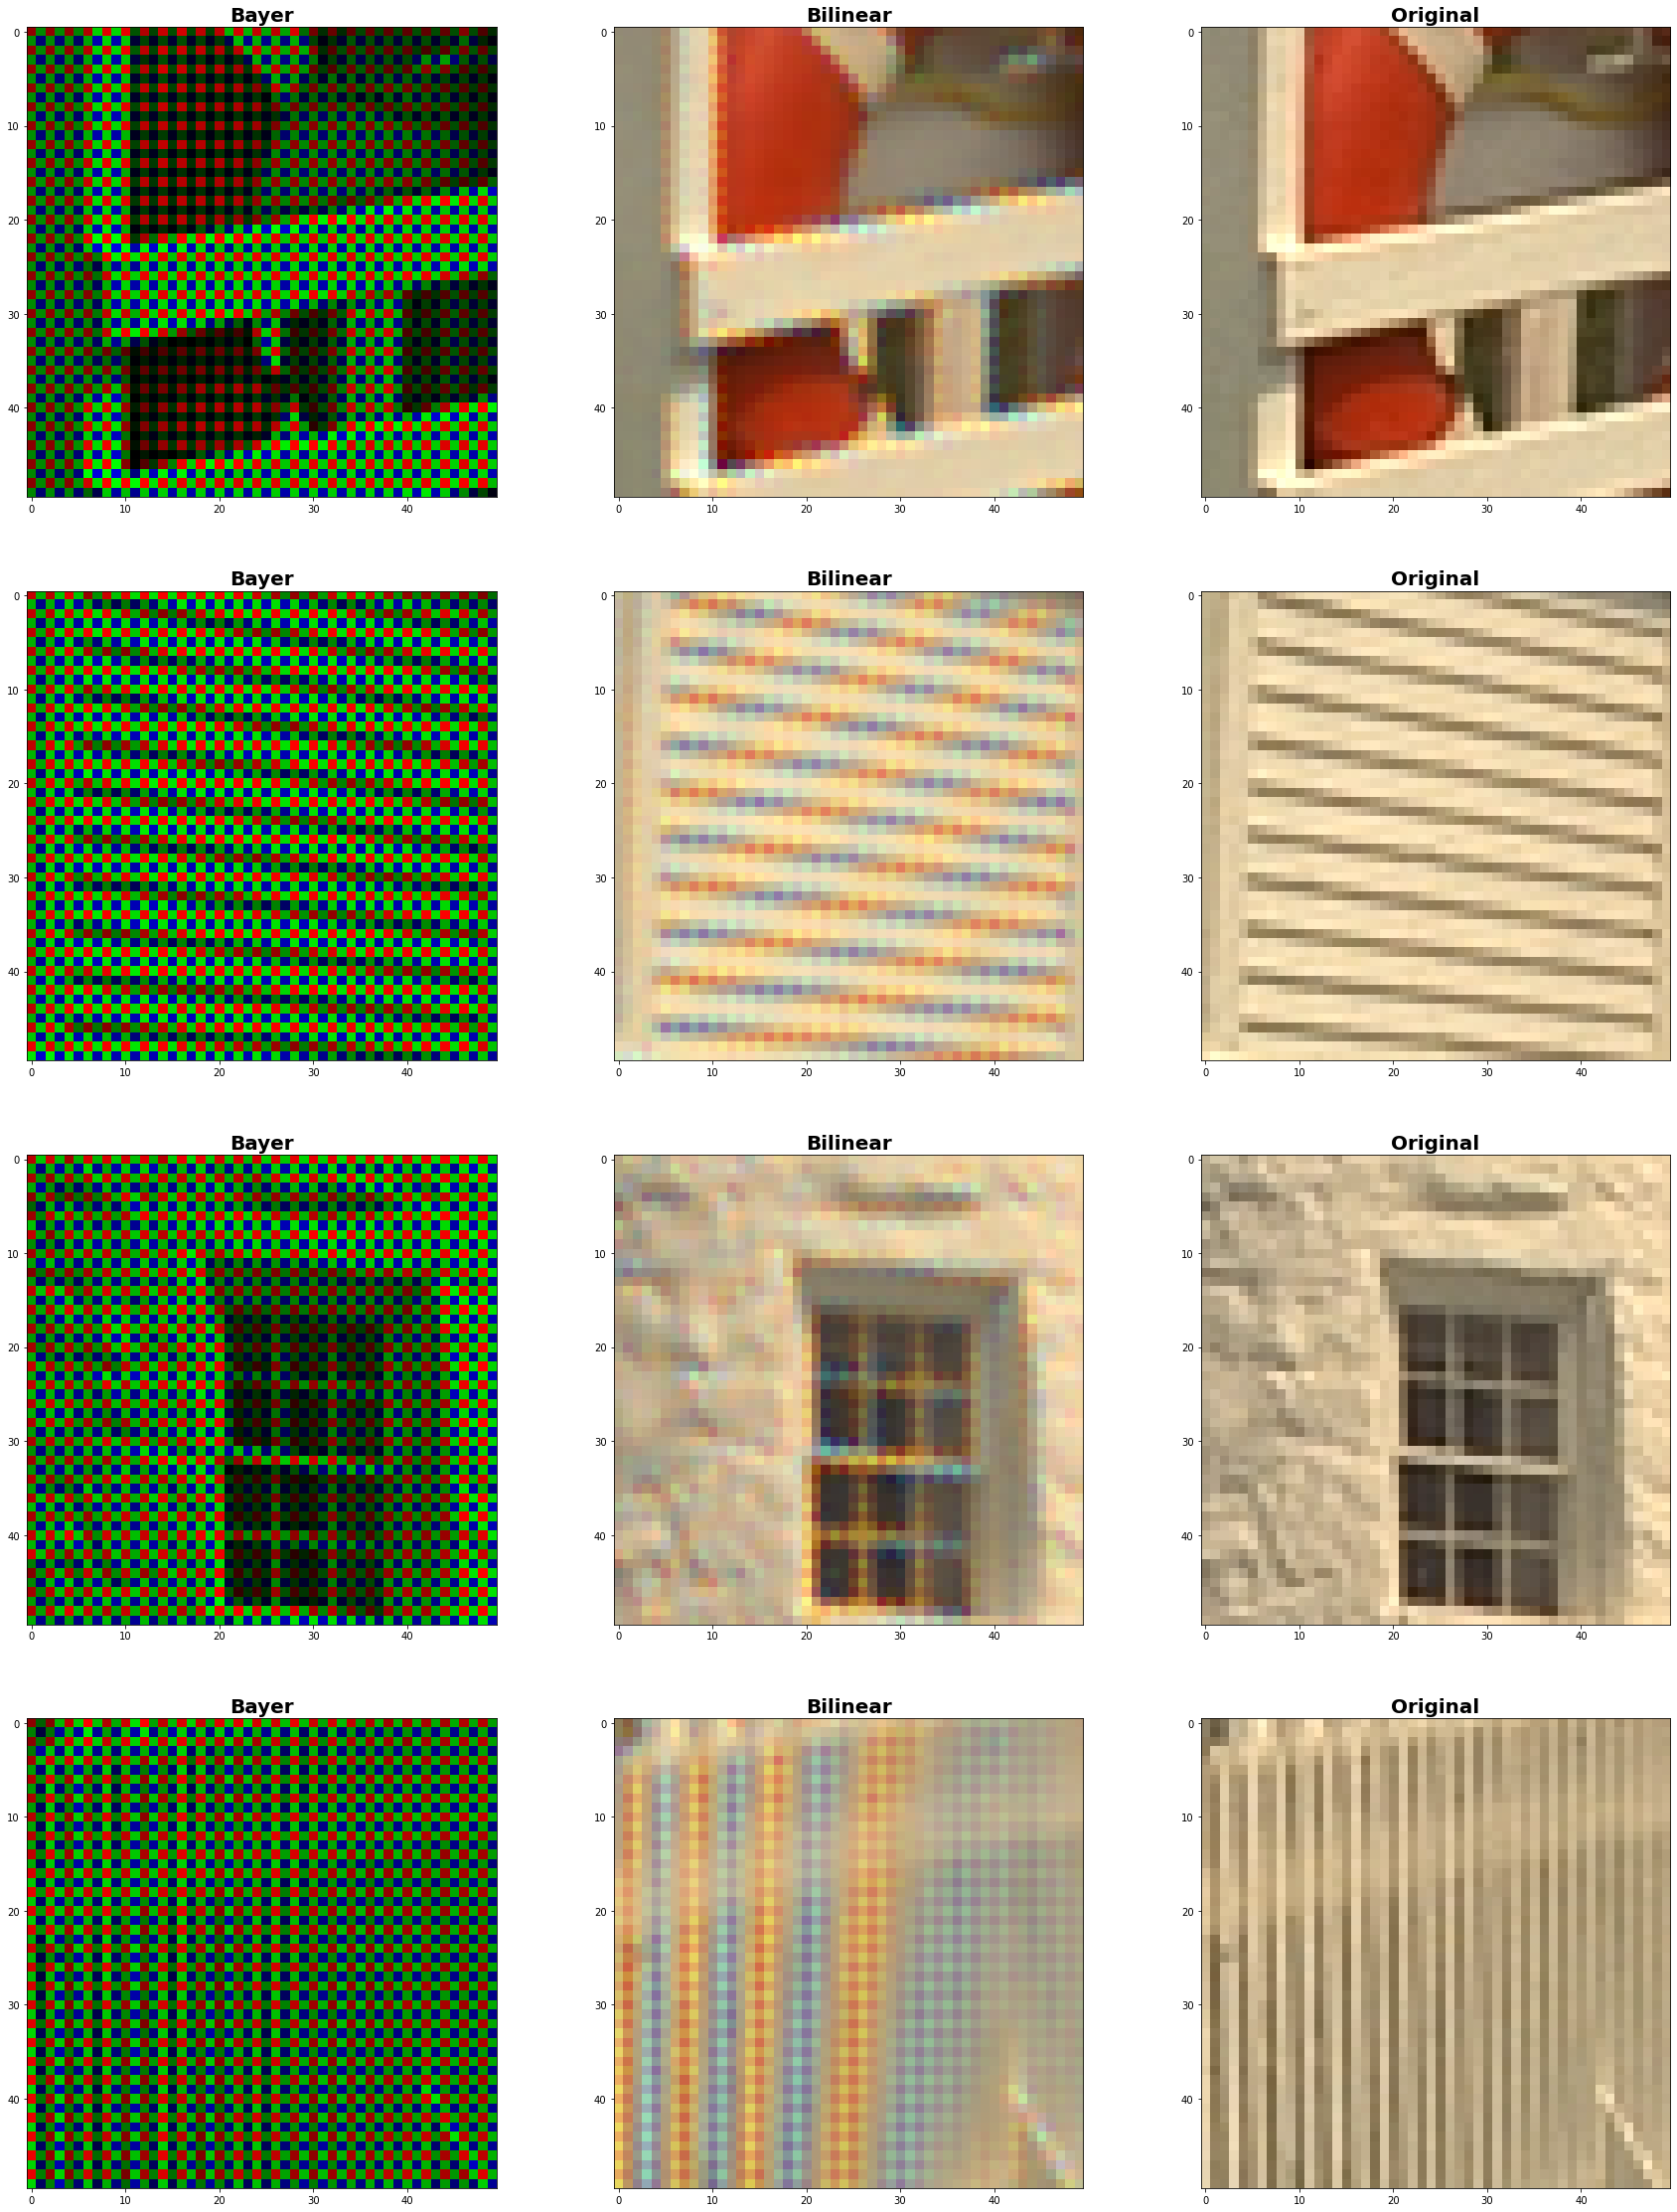

In [4]:
RinterpLin = correlate2d(R, np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 4, mode='same', boundary='symm')
GinterpLin = correlate2d(G, np.array([[0, 1, 0], [1, 4, 1], [0, 1, 0]]) / 4, mode='same', boundary='symm')
BinterpLin = correlate2d(B, np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 4, mode='same', boundary='symm')

debayerLin = np.stack((RinterpLin, GinterpLin, BinterpLin), axis=-1)

rgbLin = (np.clip(debayerLin, 0.0, 1.0) * 255).astype(np.uint8)
pltCompare([bayer3c, rgbLin, color], ['Bayer', 'Bilinear', 'Original'])
cv.imwrite('linear.ppm', cv.cvtColor(rgbLin, cv.COLOR_RGB2BGR))

# Refine Green with Gradient Detection

## Simple detection is enough.

Text(0.5, 1.0, 'Vertical Gradient')

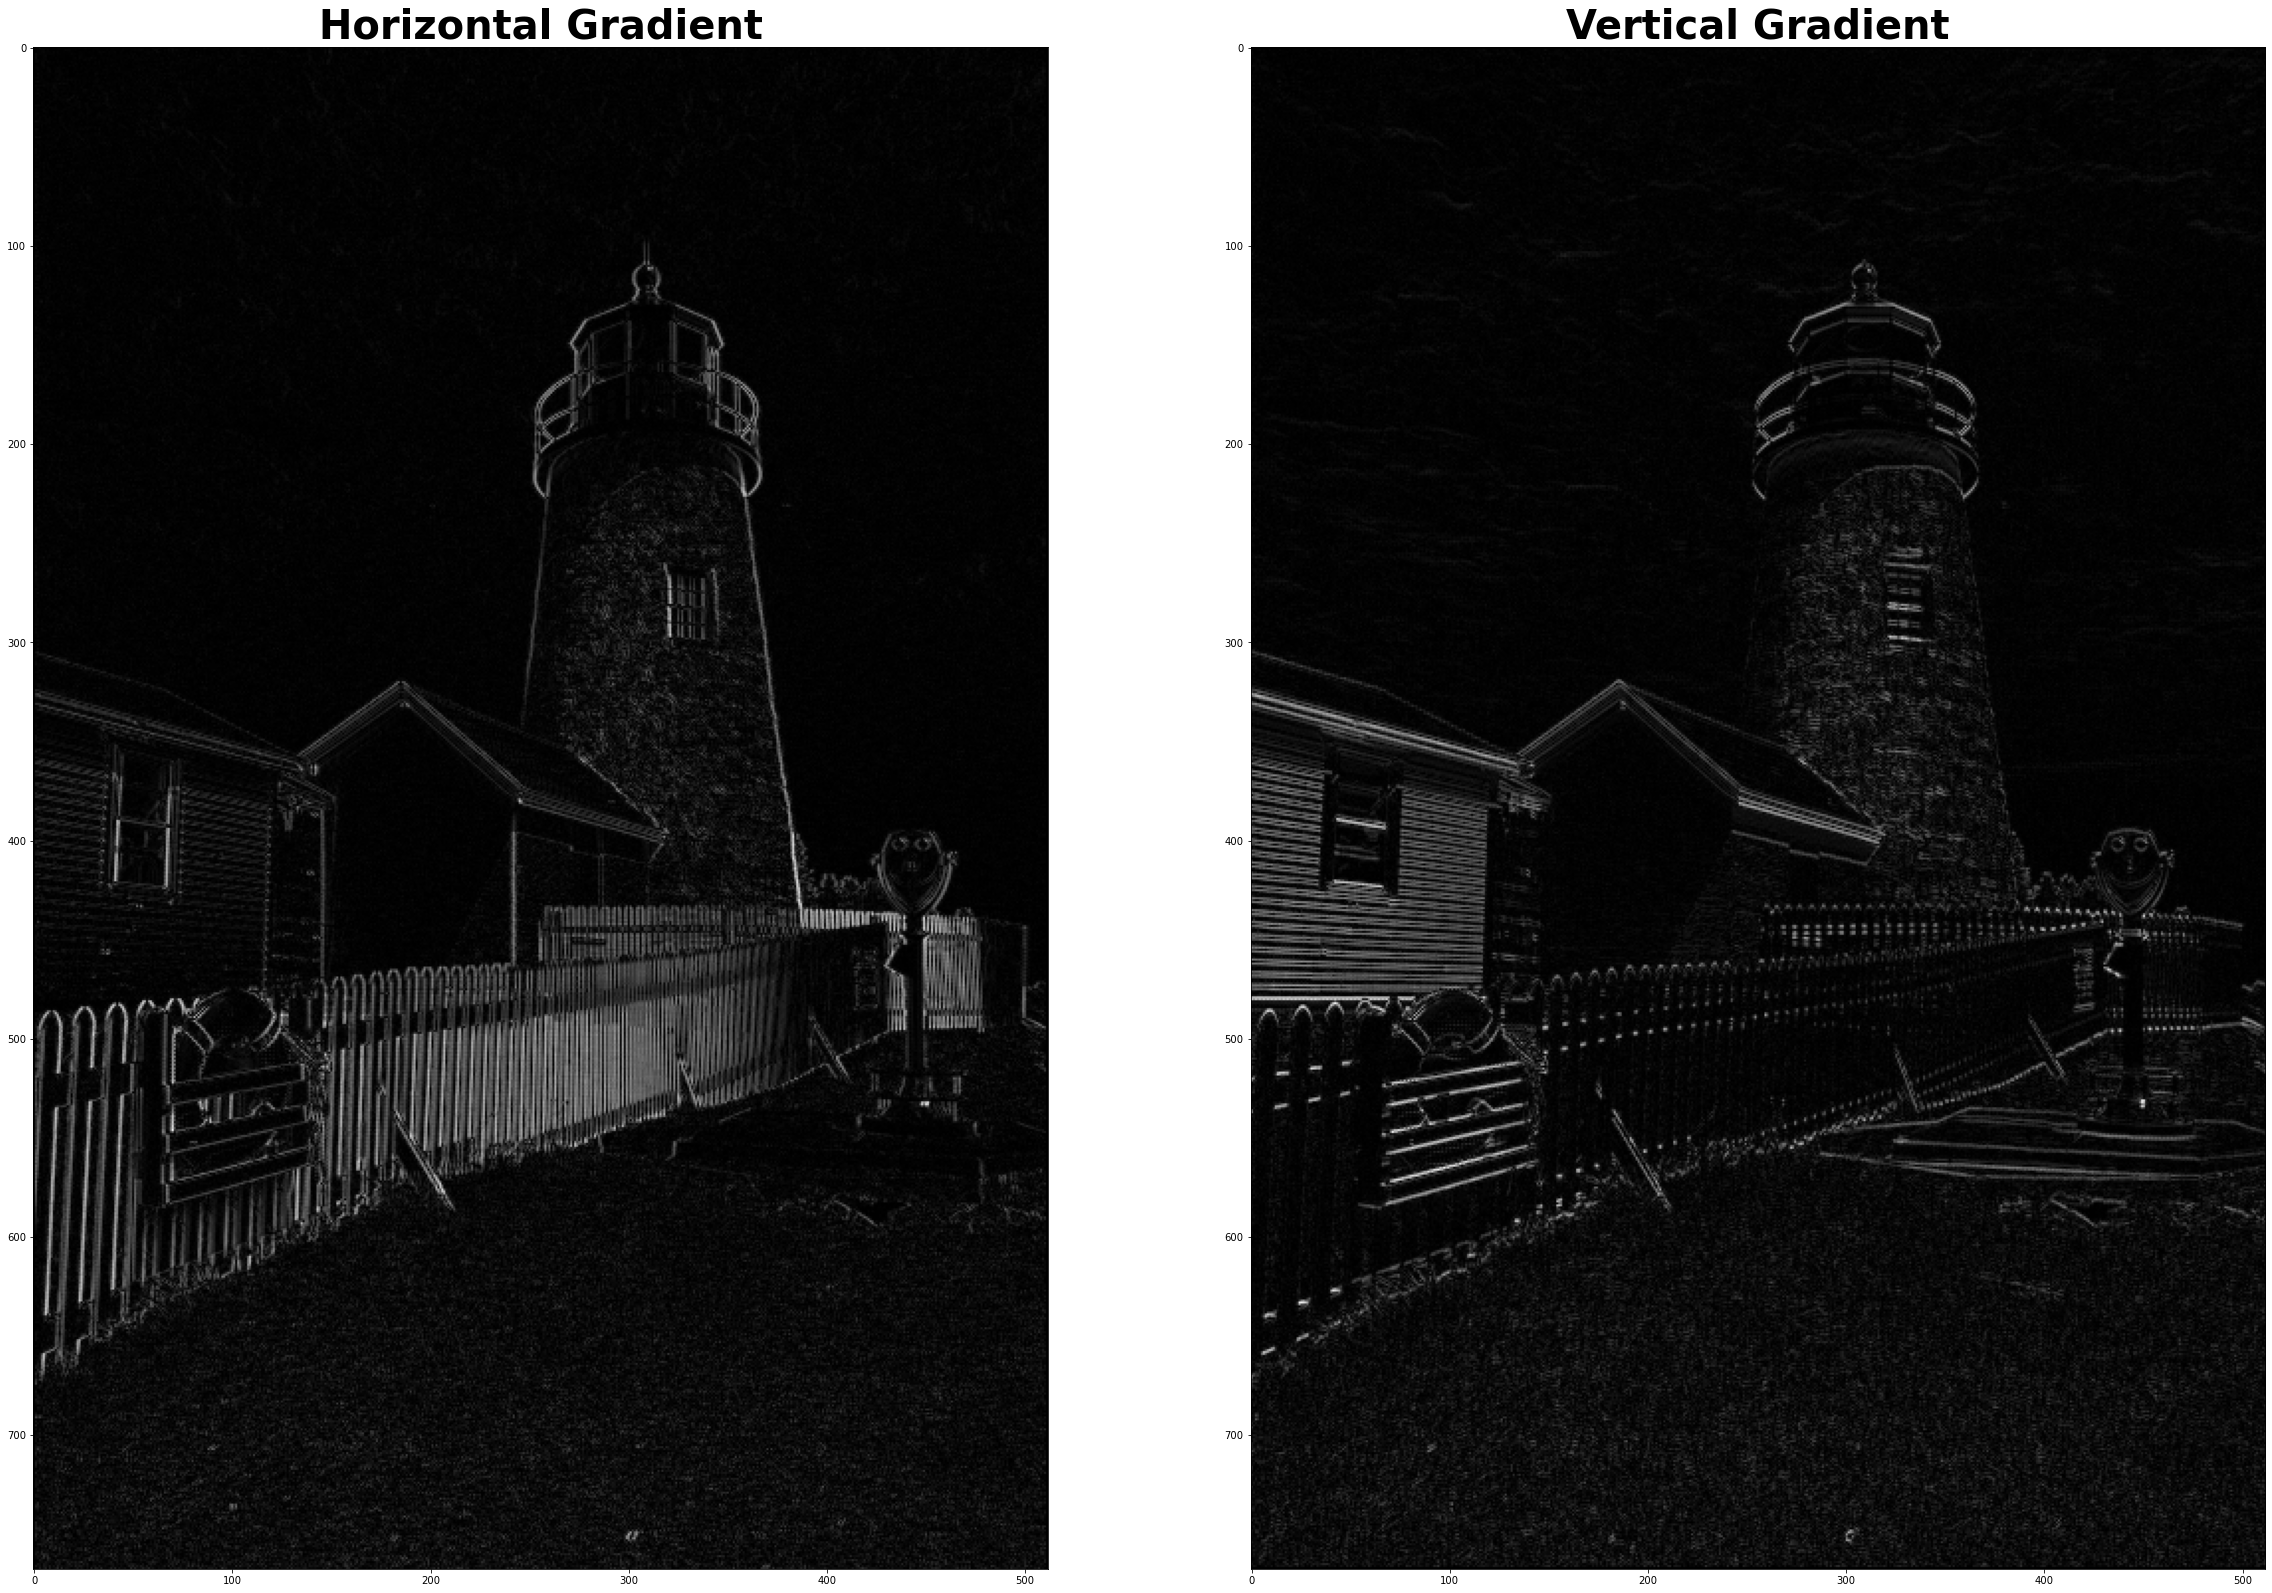

In [5]:
W = bayer.shape[1]
H = bayer.shape[0]

bayerExt = np.concatenate((bayer[1:2,:], bayer, bayer[H-2:H-1,:]), axis=0)
bayerExt = np.concatenate((bayerExt[:,1:2], bayerExt, bayerExt[:,W-2:W- 1]), axis=1)
bayerExt = bayerExt / 255

gradH = np.abs(bayerExt[1:H+1, 0:W] - bayerExt[1:H+1, 2:W+2]).astype(np.float32)
gradV = np.abs(bayerExt[0:H, 1:W+1] - bayerExt[2:H+2, 1:W+1]).astype(np.float32)

rgbH = cv.cvtColor(gradH, cv.COLOR_GRAY2RGB)
rgbV = cv.cvtColor(gradV, cv.COLOR_GRAY2RGB)
plt.figure(figsize=(40, 30))
fig = plt.subplot(1, 2, 1)
fig.imshow(rgbH)
plt.gca().set_title("Horizontal Gradient", fontweight="bold", size=40)
fig = plt.subplot(1, 2, 2)
fig.imshow(rgbV)
plt.gca().set_title("Vertical Gradient", fontweight="bold", size=40)


True

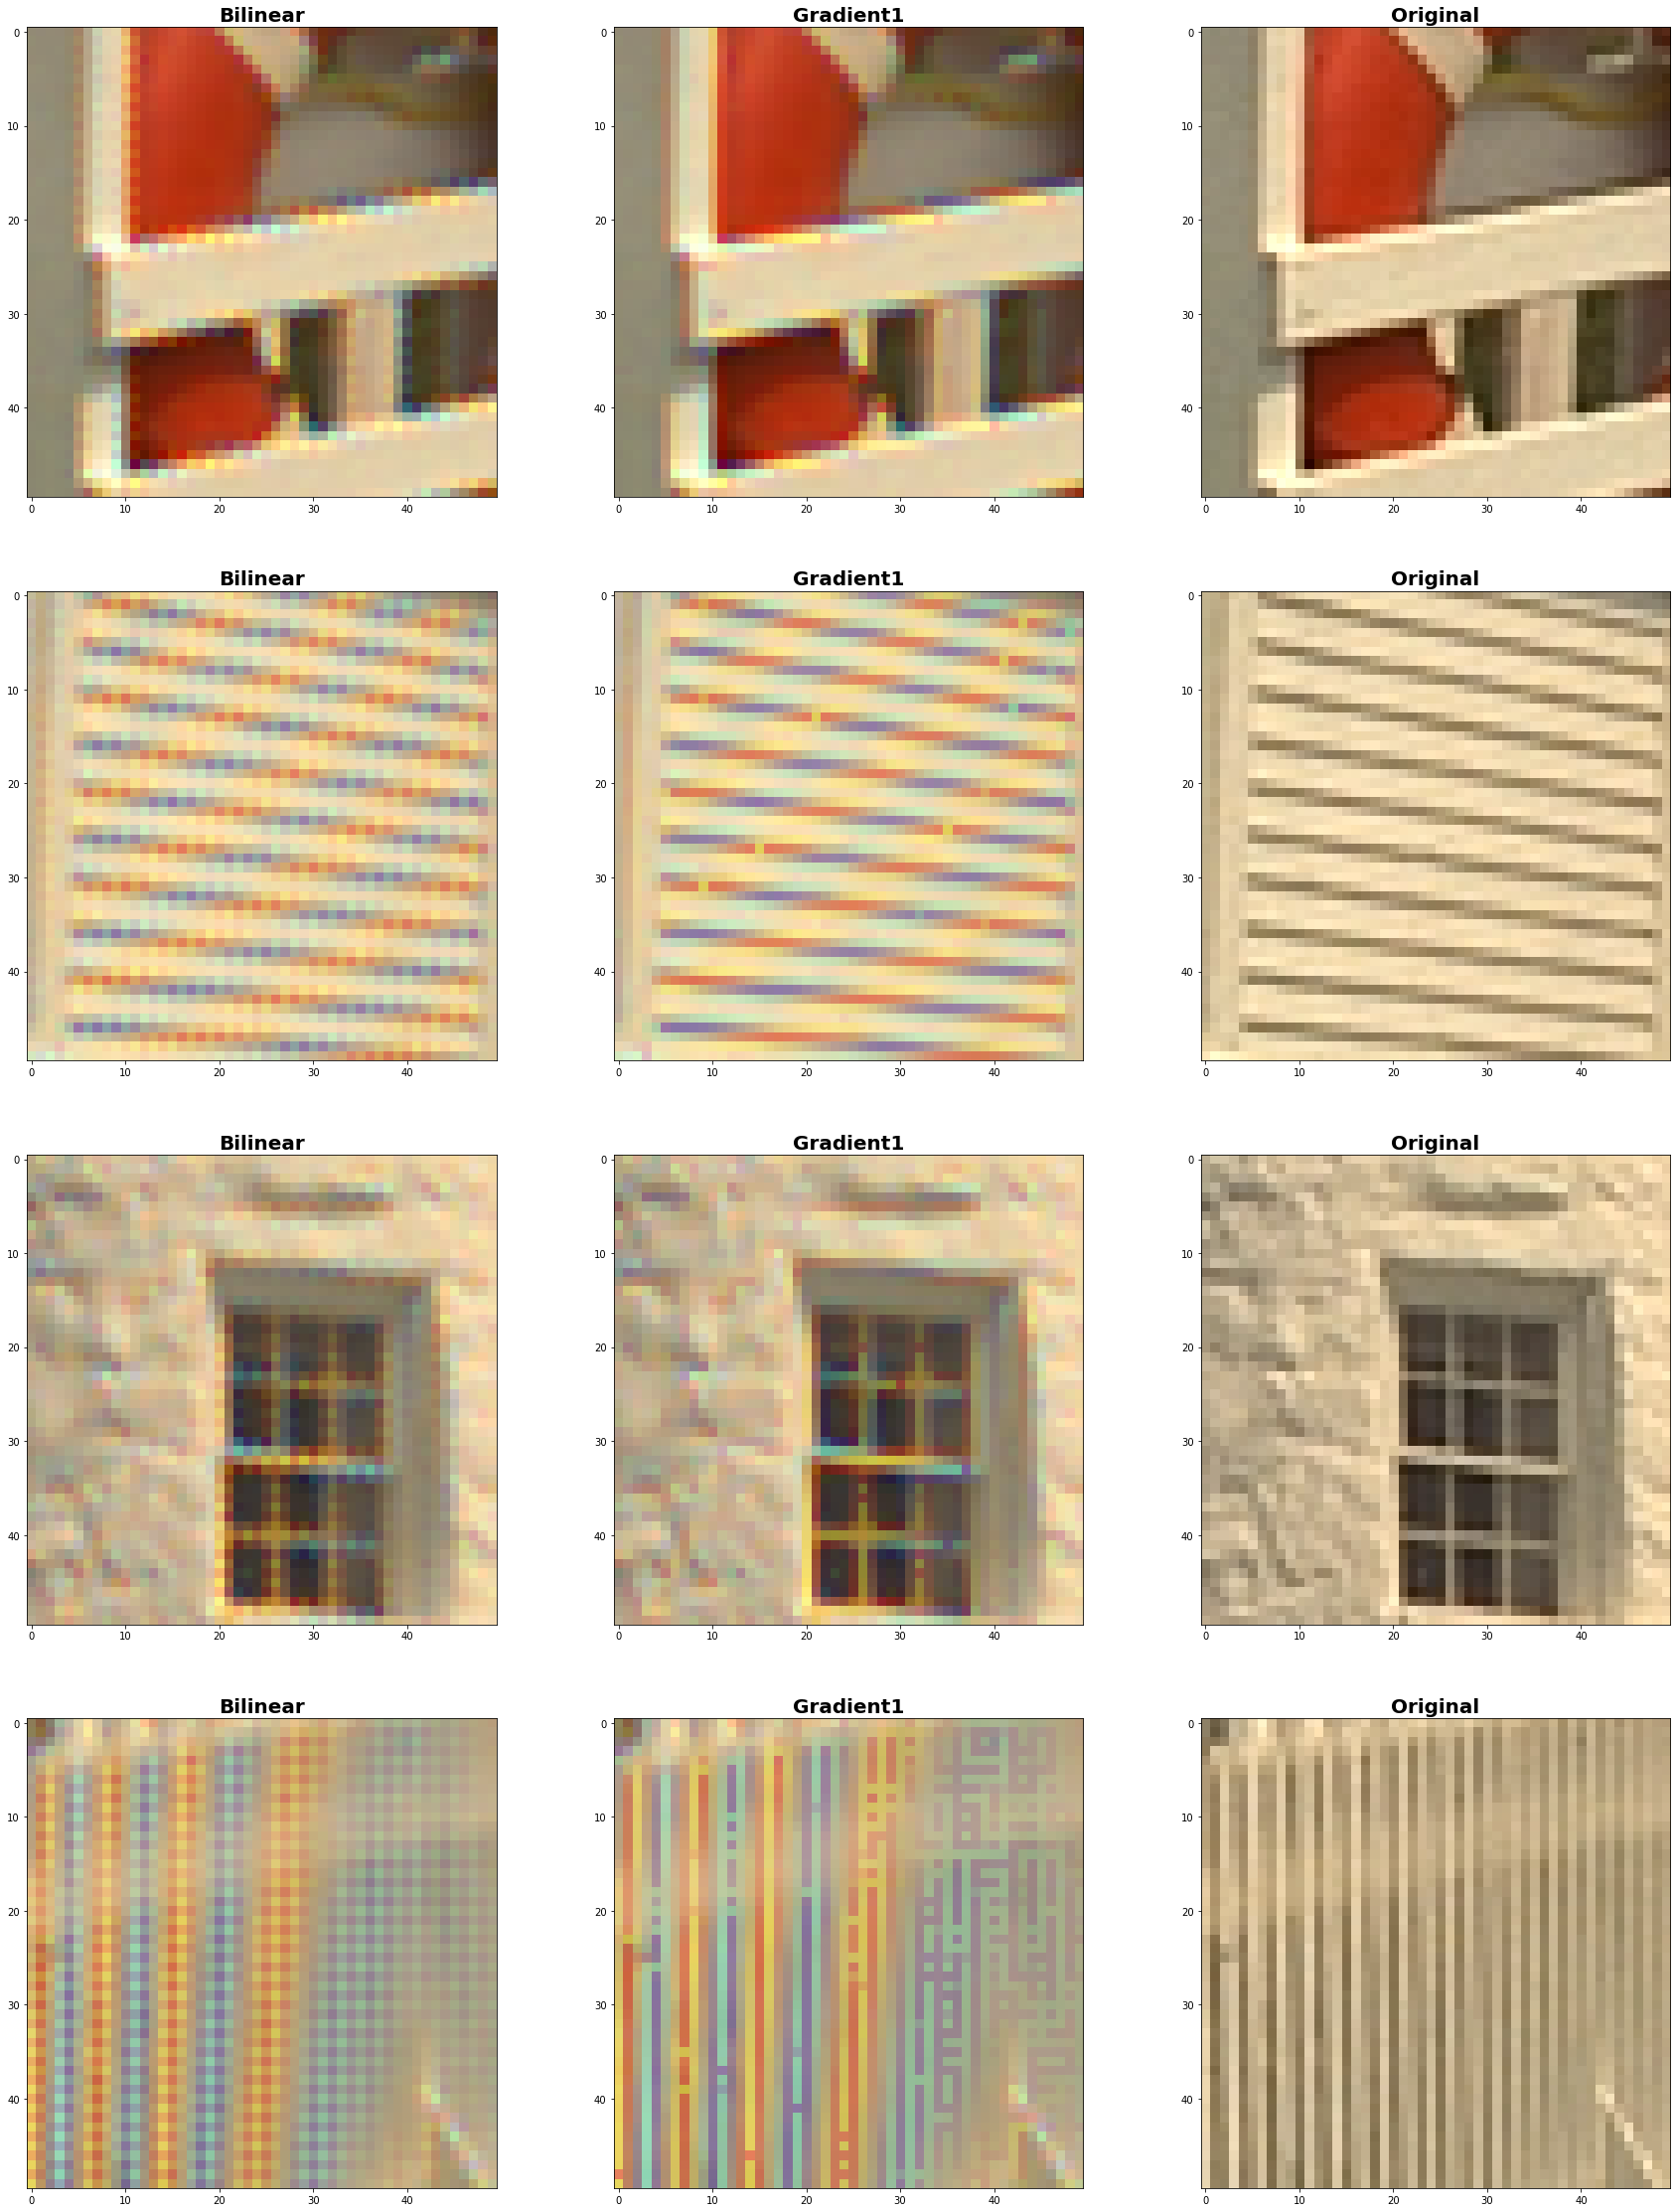

In [6]:
GinterpH = correlate2d(G, np.array([[0, 0, 0], [2, 4, 2], [0, 0, 0]]) / 4, mode='same', boundary='symm')
GinterpV = correlate2d(G, np.array([[0, 2, 0], [0, 4, 0], [0, 2, 0]]) / 4, mode='same', boundary='symm')
GinterpHV = correlate2d(G, np.array([[0, 1, 0], [1, 4, 1], [0, 1, 0]]) / 4, mode='same', boundary='symm')
GinterpGrad = (gradV > gradH) * GinterpH + (gradV < gradH) * GinterpV + (gradV == gradH) * GinterpHV
debayerGrad = np.stack((RinterpLin, GinterpGrad, BinterpLin), axis=-1)
rgbGrad = (np.clip(debayerGrad, 0.0, 1.0) * 255).astype(np.uint8)
pltCompare([rgbLin, rgbGrad, color], ['Bilinear', 'Gradient1', 'Original'])
cv.imwrite('gradient1.ppm', cv.cvtColor(rgbGrad, cv.COLOR_RGB2BGR))

# Leverage Green Channel to Interpolate Red/Blue
### Theory: Color Difference is Changing Slowly

Text(0.5, 0.92, 'B - G derivative Y')

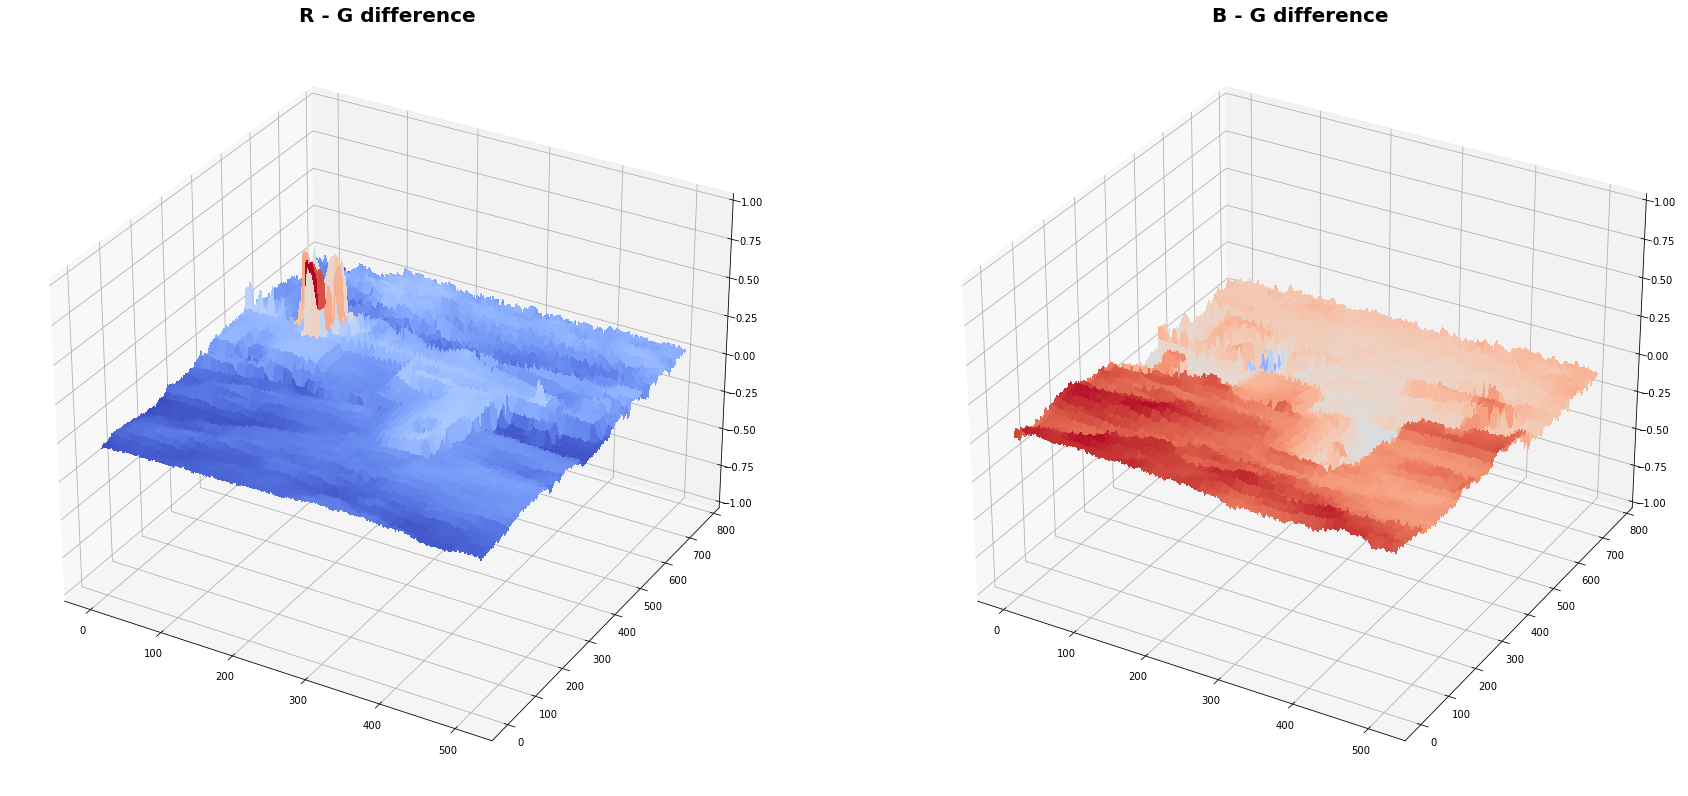

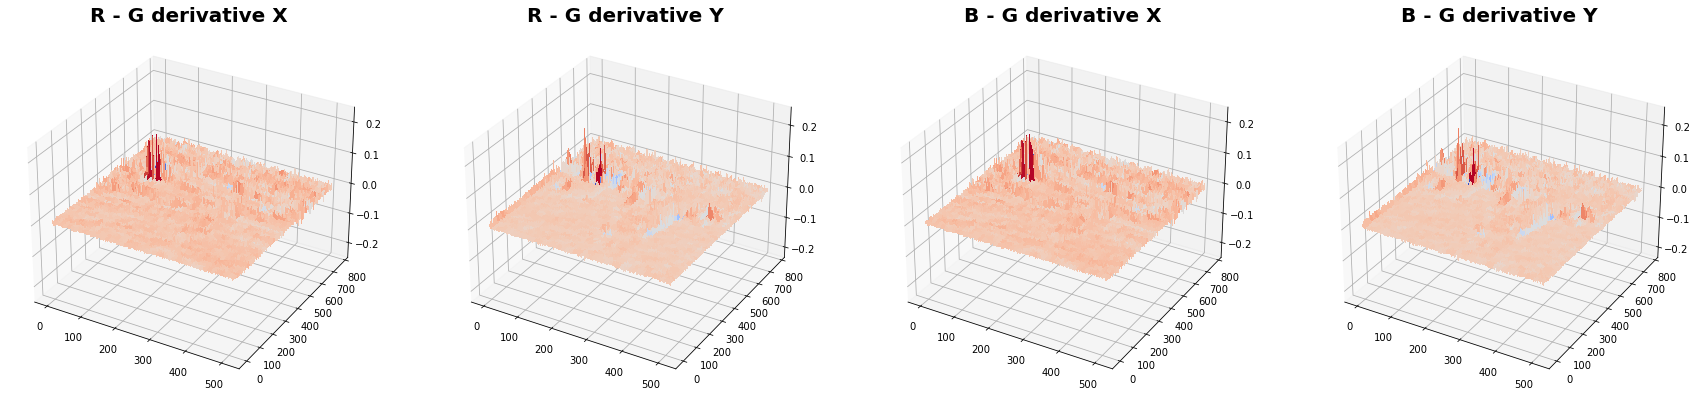

In [7]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

_RminusG = color[:,:,0] / 255 - color[:,:,1] / 255
_BminusG = color[:,:,2] / 255 - color[:,:,1] / 255
_x = np.linspace(0, W-1, W)
_y = np.linspace(0, H-1, H)
_xs, _ys = np.meshgrid(_x, _y, sparse=True)

# difference
fig, ax = plt.subplots(1, 2, figsize=(30, 15), subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(_xs, _ys, _RminusG, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax[0].set_zlim(-1., 1.)
ax[0].set_title('R - G difference', fontweight="bold", size=20)
surf = ax[1].plot_surface(_xs, _ys, _BminusG, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax[1].set_zlim(-1., 1.)
ax[1].set_title('B - G difference', fontweight="bold", size=20)

# 1st derivative of difference
_gx, _gy = np.gradient(_RminusG)
fig, ax = plt.subplots(1, 4, figsize=(30, 10), subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(_xs, _ys, _gx, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax[0].set_title('R - G derivative X', fontweight="bold", size=20)
surf = ax[1].plot_surface(_xs, _ys, _gy, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax[1].set_title('R - G derivative Y', fontweight="bold", size=20)
_gx, _gy = np.gradient(_RminusG)
surf = ax[2].plot_surface(_xs, _ys, _gx, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax[2].set_title('B - G derivative X', fontweight="bold", size=20)
surf = ax[3].plot_surface(_xs, _ys, _gy, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax[3].set_title('B - G derivative Y', fontweight="bold", size=20)


# Refine Red/Blue

True

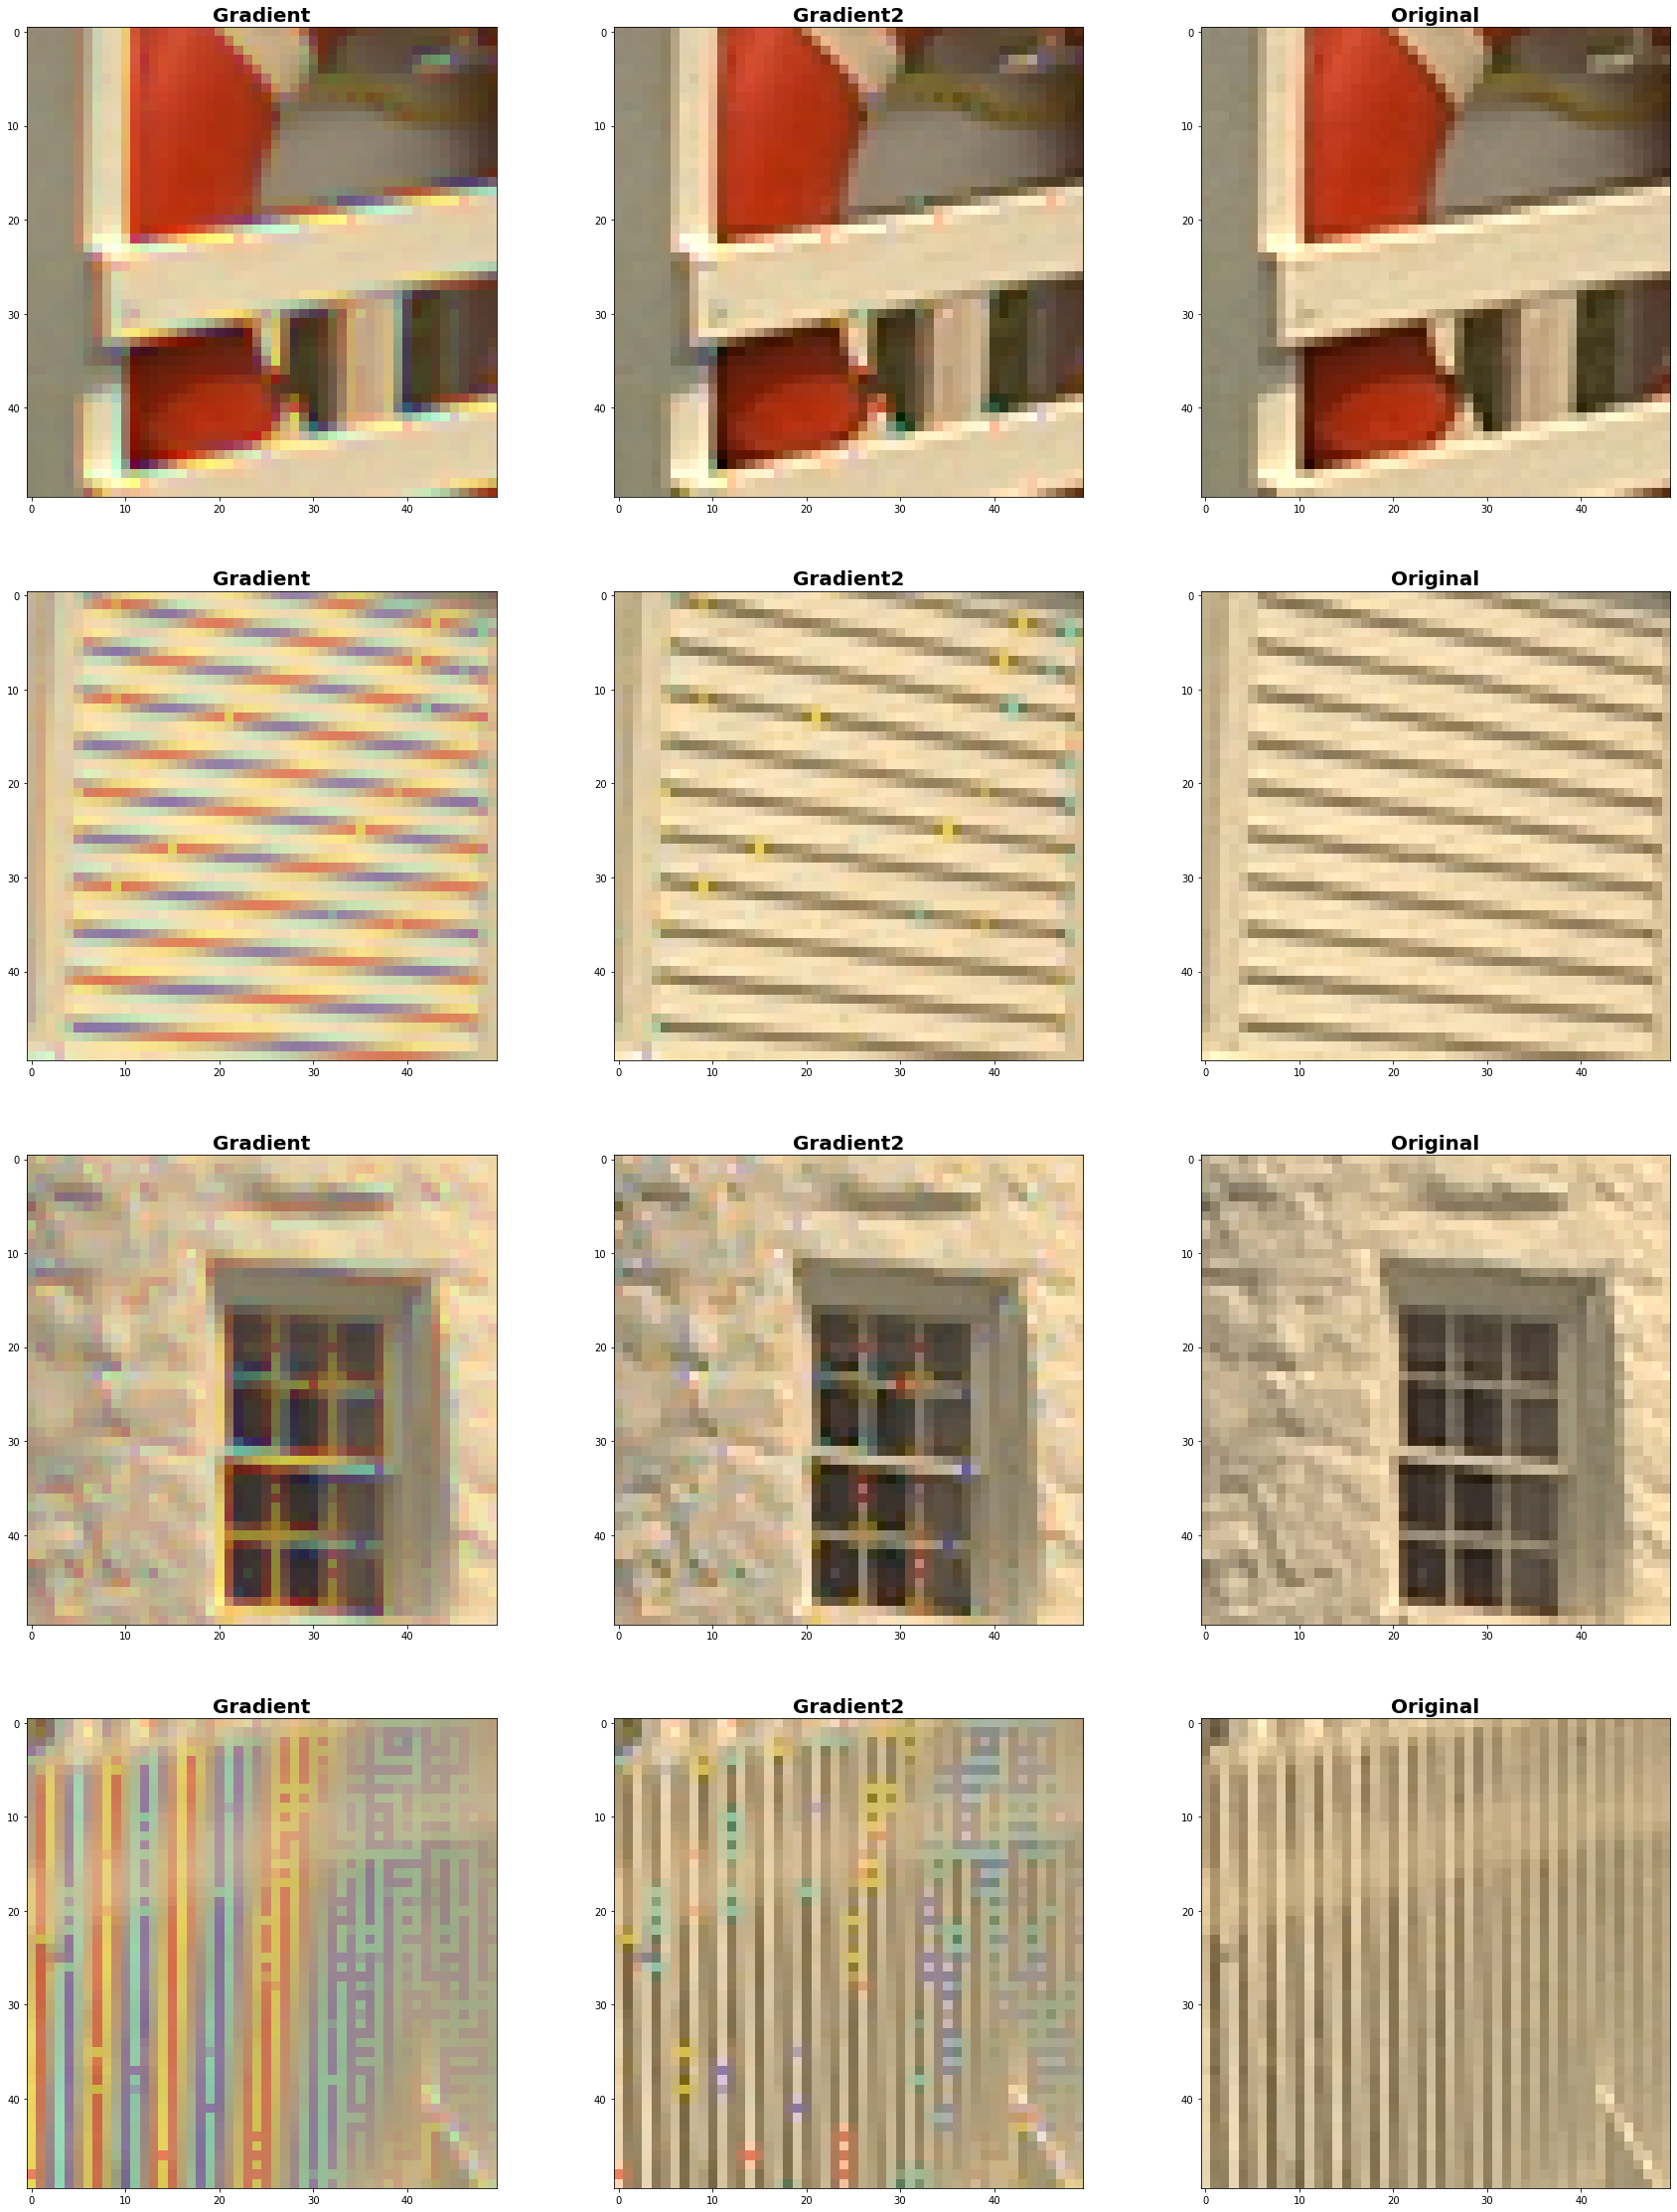

In [8]:
tmp = R - GinterpGrad
RminusG = np.zeros_like(tmp)
RminusG[0::2, 0::2] = tmp[0::2, 0::2]
RminusGinterp = correlate2d(RminusG, np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 4, mode='same', boundary='symm')
RinterpGrad = np.clip(GinterpGrad + RminusGinterp, 0., 1.)

tmp = B - GinterpGrad
BminusG = np.zeros_like(tmp)
BminusG[1::2, 1::2] = tmp[1::2, 1::2]
BminusGinterp = correlate2d(BminusG, np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 4, mode='same', boundary='symm')
BinterpGrad = np.clip(GinterpGrad + BminusGinterp, 0., 1.)

debayerGrad2 = np.stack((RinterpGrad, GinterpGrad, BinterpGrad), axis=-1)

rgbGrad2 = (np.clip(debayerGrad2, 0.0, 1.0) * 255).astype(np.uint8)
pltCompare([rgbGrad, rgbGrad2, color], ['Gradient', 'Gradient2', 'Original'])
cv.imwrite('gradient2.ppm', cv.cvtColor(rgbGrad2, cv.COLOR_RGB2BGR))

# Several methods fine-tuned gradient detection in early days (1999~2006)
### [VNG (Variable Number of Gradients)](https://web.archive.org/web/20120422035609/http://scien.stanford.edu/pages/labsite/1999/psych221/projects/99/tingchen/main.htm)
### [PPG (Pixel Grouping)](https://web.archive.org/web/20160923211135/https://sites.google.com/site/chklin/demosaic/)

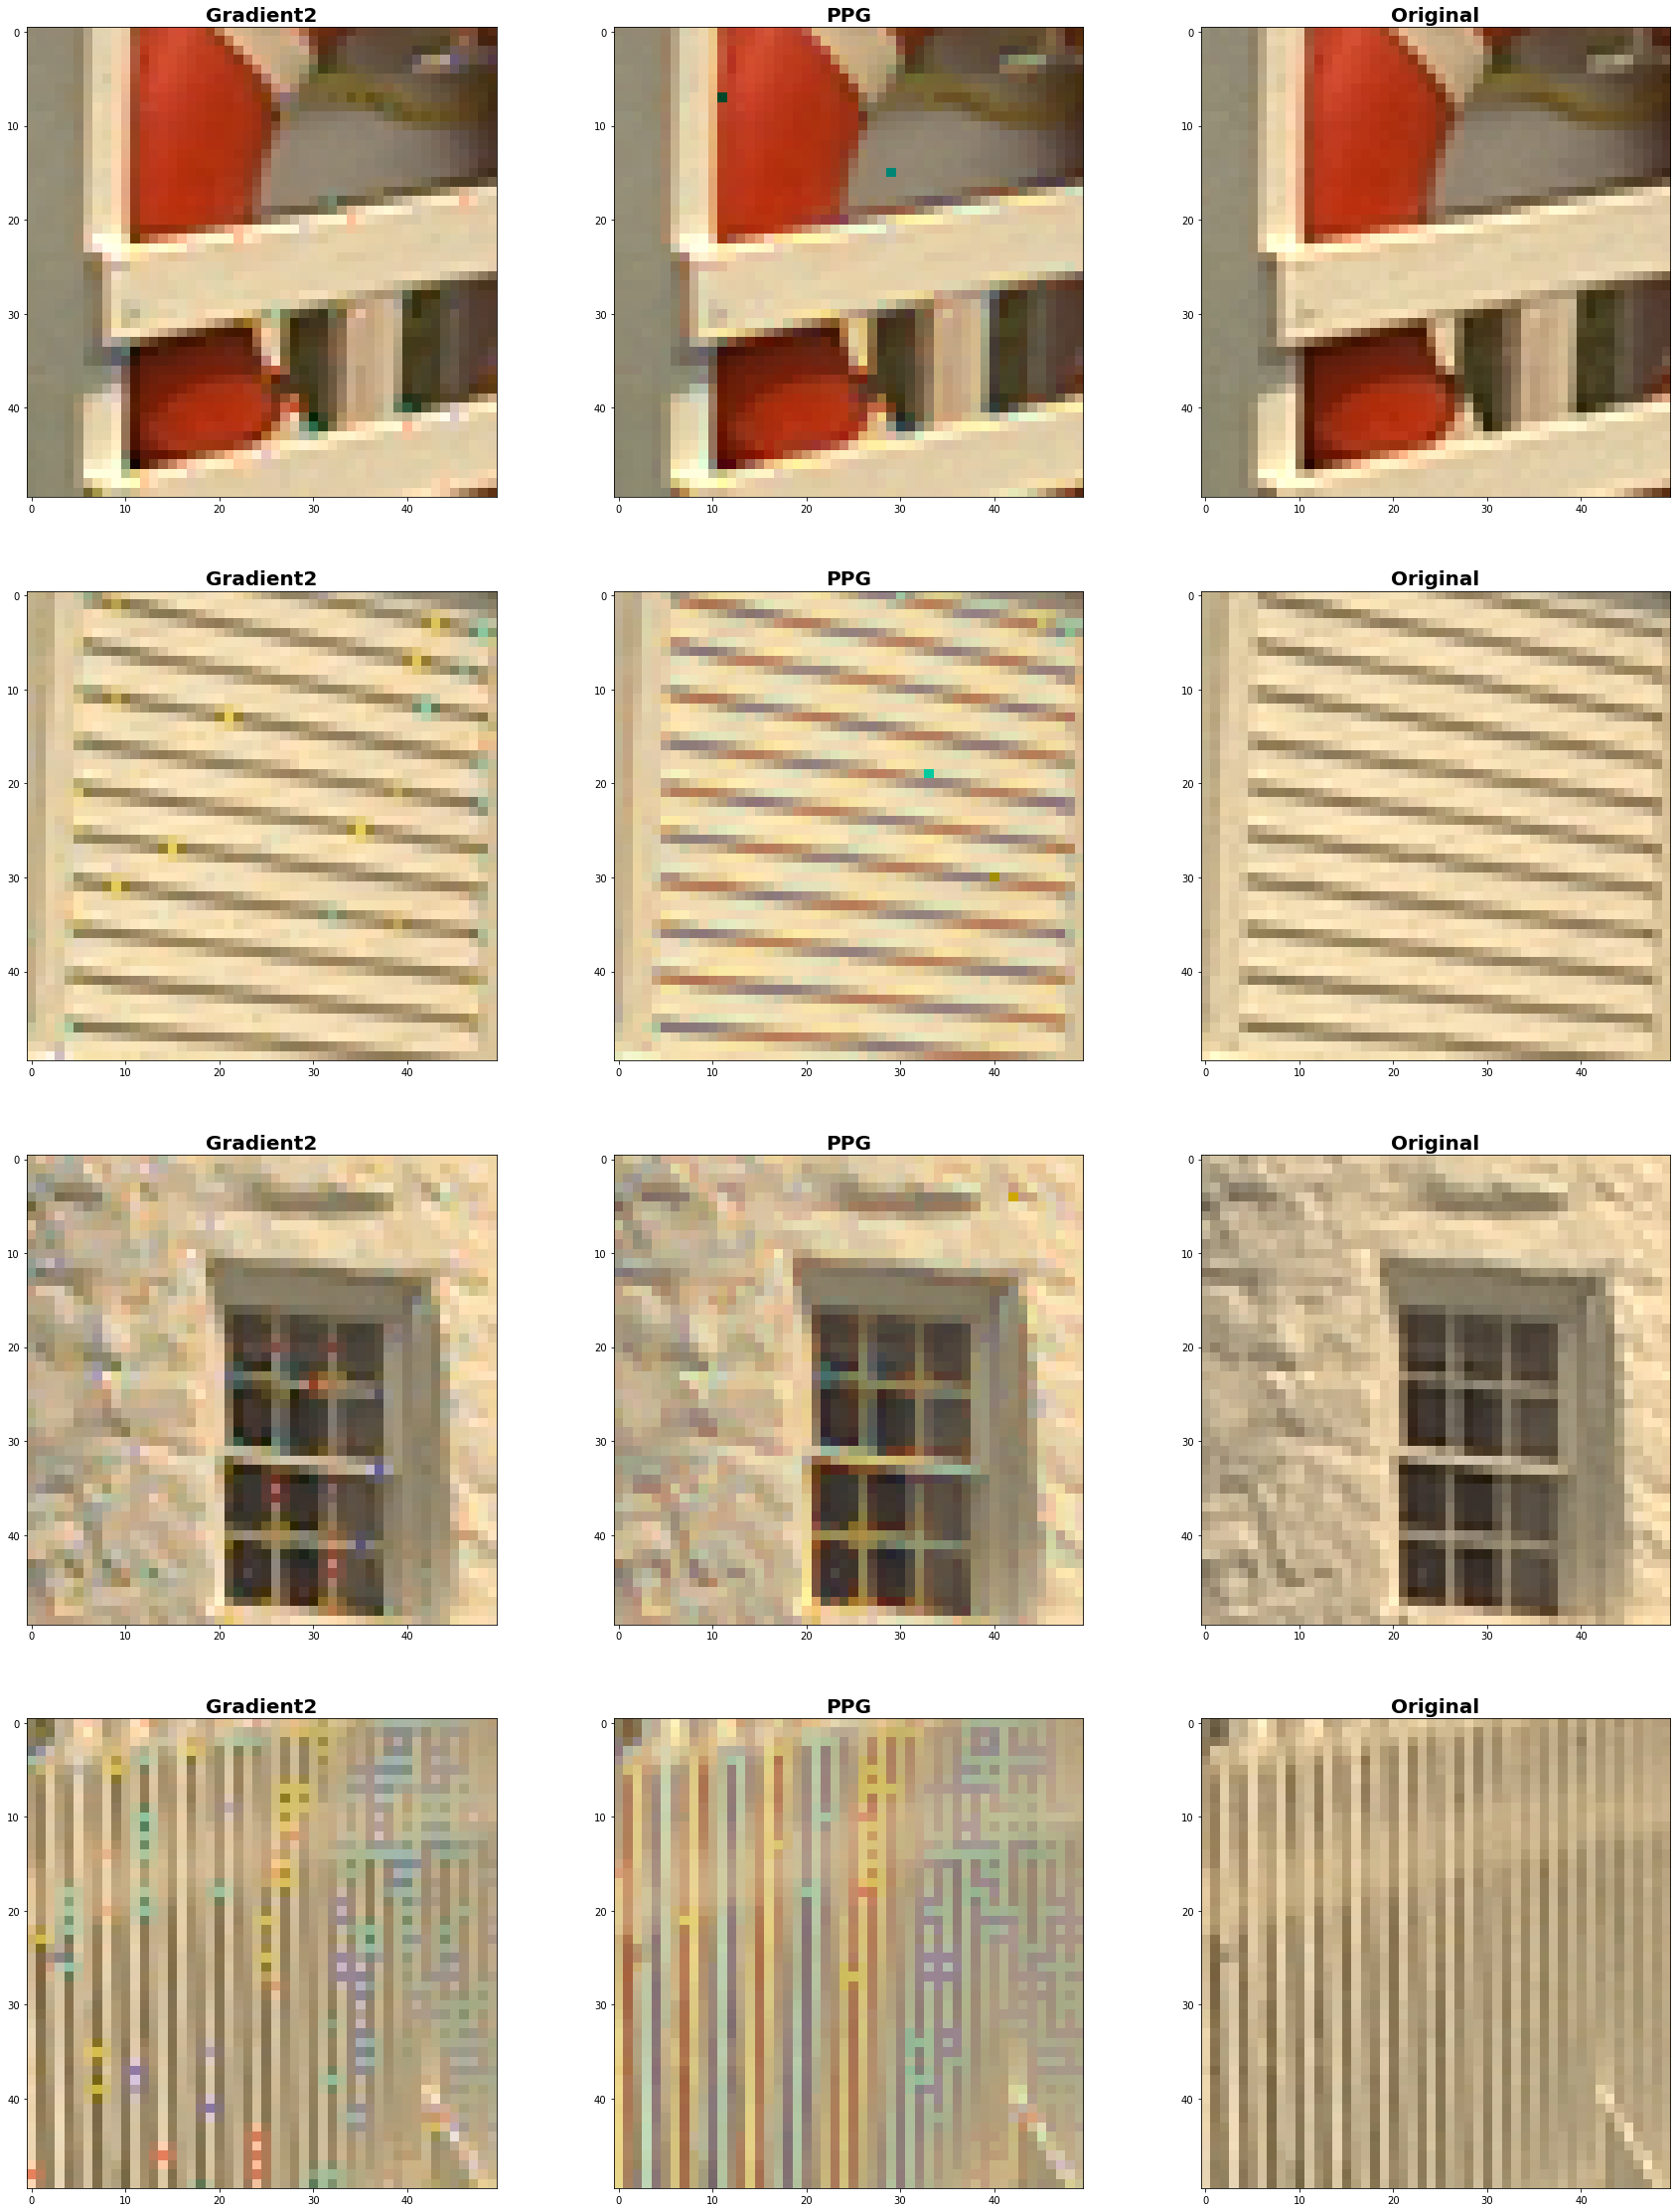

In [9]:
W = bayer.shape[1]
H = bayer.shape[0]
bayerExt = np.concatenate((bayer[1:2,:], bayer, bayer[H-2:H-1,:]), axis=0)
bayerExt = np.concatenate((bayer[2:3,:], bayerExt, bayer[H-3:H-2,:]), axis=0)
bayerExt = np.concatenate((bayerExt[:,1:2], bayerExt, bayerExt[:,W-2:W-1]), axis=1)
bayerExt = np.concatenate((bayerExt[:,3:4], bayerExt, bayerExt[:,W-4:W-3]), axis=1)
bayerExt = bayerExt / 255

# stage 1: green interpolation based on N/E/W/S directions
gradN = np.abs(bayerExt[0:H, 2:W+2] - bayerExt[2:H+2, 2:W+2]) * 2 + np.abs(bayerExt[1:H+1, 2:W+2] - bayerExt[3:H+3, 2:W+2])
gradS = np.abs(bayerExt[2:H+2, 2:W+2] - bayerExt[4:H+4, 2:W+2]) * 2 + np.abs(bayerExt[1:H+1, 2:W+2] - bayerExt[3:H+3, 2:W+2])
gradW = np.abs(bayerExt[2:H+2, 0:W] - bayerExt[2:H+2, 2:W+2]) * 2 + np.abs(bayerExt[2:H+2, 1:W+1] - bayerExt[2:H+2, 3:W+3])
gradE = np.abs(bayerExt[2:H+2, 2:W+2] - bayerExt[2:H+2, 4:W+4]) * 2 + np.abs(bayerExt[2:H+2, 1:W+1] - bayerExt[2:H+2, 3:W+3])

GinterpN = correlate2d(R+B, np.array([[-1],[0],[1],[0],[0]])/4, mode='same', boundary='symm') \
        + correlate2d(G, np.array([[0],[3],[4],[1],[0]])/4, mode='same', boundary='symm')
GinterpS = correlate2d(R+B, np.array([[0],[0],[1],[0],[-1]])/4, mode='same', boundary='symm') \
        + correlate2d(G, np.array([[0],[1],[4],[3],[0]])/4, mode='same', boundary='symm')
GinterpW = correlate2d(R+B, np.array([[-1,0,1,0,0]])/4, mode='same', boundary='symm') \
        + correlate2d(G, np.array([[0,3,4,1,0]])/4, mode='same', boundary='symm')
GinterpE = correlate2d(R+B, np.array([[0,0,1,0,-1]])/4, mode='same', boundary='symm') \
        + correlate2d(G, np.array([[0,1,4,3,0]])/4, mode='same', boundary='symm')
ixMin = np.argmin(np.stack((gradN, gradS, gradW, gradE), axis=-1), axis=2)
GinterpPPG = (ixMin == 0) * GinterpN + (ixMin == 1) * GinterpS + (ixMin == 2) * GinterpW + (ixMin == 3) * GinterpE

# stage 2: red/blue interpolation in green positions
Gext = np.concatenate((GinterpPPG[1:2, :], GinterpPPG, GinterpPPG[H-2:H-1, :]), axis=0)
Gext = np.concatenate((Gext[3:4, :], Gext, Gext[H-4:H-3, :]), axis=0)
Gext = np.concatenate((Gext[:, 1:2], Gext, Gext[:, W-2:W-1]), axis=1)
Gext = np.concatenate((Gext[:, 3:4], Gext, Gext[:, W-4:W-3]), axis=1)
Rext = np.concatenate((R[1:2, :], R, R[H-2:H-1, :]), axis=0)
Rext = np.concatenate((Rext[3:4, :], Rext, Rext[H-4:H-3, :]), axis=0)
Rext = np.concatenate((Rext[:, 1:2], Rext, Rext[:, W-2:W-1]), axis=1)
Rext = np.concatenate((Rext[:, 3:4], Rext, Rext[:, W-4:W-3]), axis=1)
Bext = np.concatenate((B[1:2, :], B, B[H-2:H-1, :]), axis=0)
Bext = np.concatenate((Bext[3:4, :], Bext, Bext[H-4:H-3, :]), axis=0)
Bext = np.concatenate((Bext[:, 1:2], Bext, Bext[:, W-2:W-1]), axis=1)
Bext = np.concatenate((Bext[:, 3:4], Bext, Bext[:, W-4:W-3]), axis=1)

alphaH = (Gext[2:H+2,3:W+3] - Gext[2:H+2,2:W+2]) / np.clip(Gext[2:H+2,3:W+3] - Gext[2:H+2,1:W+1], 10**(-10), 1)
alphaV = (Gext[3:H+3,2:W+2] - Gext[2:H+2,2:W+2]) / np.clip(Gext[3:H+3,2:W+2] - Gext[1:H+1,2:W+2], 10**(-10), 1)

hType1 = np.logical_and(alphaH > 0, alphaH < 1)
vType1 = np.logical_and(alphaV > 0, alphaV < 1)
hType2 = np.logical_not(hType1)
vType2 = np.logical_not(vType1)

RinterpPPG = R.copy()
RinterpPPG += GRcfa * hType1 * (alphaH * Rext[2:H+2, 1:W+1] + (1-alphaH) * Rext[2:H+2, 3:W+3])
RinterpPPG += GRcfa * hType2 * (correlate2d(R, np.array([[1,0,1]])/2,mode='same', boundary='symm') + correlate2d(GinterpPPG, np.array([[-1,2,-1]])/4,mode='same', boundary='symm'))
RinterpPPG += GBcfa * vType1 * (alphaV * Rext[1:H+1, 2:W+2] + (1-alphaV) * Rext[3:H+3, 2:W+2])
RinterpPPG += GBcfa * vType2 * (correlate2d(R, np.array([[1],[0],[1]])/2,mode='same', boundary='symm') + correlate2d(GinterpPPG, np.array([[-1],[2],[-1]])/4,mode='same', boundary='symm'))

BinterpPPG = B.copy()
BinterpPPG += GBcfa * hType1 * (alphaH * Bext[2:H+2, 1:W+1] + (1-alphaH) * Bext[2:H+2, 3:W+3])
BinterpPPG += GBcfa * hType2 * (correlate2d(B, np.array([[1,0,1]])/2,mode='same', boundary='symm') + correlate2d(GinterpPPG, np.array([[-1,2,-1]])/4,mode='same', boundary='symm'))
BinterpPPG += GRcfa * vType1 * (alphaV * Bext[1:H+1, 2:W+2] + (1-alphaV) * Bext[3:H+3, 2:W+2])
BinterpPPG += GRcfa * vType2 * (correlate2d(B, np.array([[1],[0],[1]])/2,mode='same', boundary='symm') + correlate2d(GinterpPPG, np.array([[-1],[2],[-1]])/4,mode='same', boundary='symm'))

# stage 3: red/blue interpolation in non-green positions
grad45 = np.abs(bayerExt[1:H+1, 3:W+3] - bayerExt[3:H+3, 1:W+1]) + np.abs(bayerExt[0:H, 4:W+4] - bayerExt[2:H+2, 2:W+2]) \
        + np.abs(bayerExt[2:H+2, 2:W+2] - bayerExt[4:H+4, 0:W]) + np.abs(Gext[1:H+1, 3:W+3] - Gext[2:H+2, 2:W+2]) \
        + np.abs(Gext[2:H+2, 2:W+2] - Gext[3:H+3, 1:W+1])
grad135 = np.abs(bayerExt[1:H+1, 1:W+1] - bayerExt[3:H+3, 3:W+3]) + np.abs(bayerExt[0:H, 0:W] - bayerExt[2:H+2, 2:W+2]) \
        + np.abs(bayerExt[2:H+2, 2:W+2] - bayerExt[4:H+4, 4:W+4]) + np.abs(Gext[1:H+1, 1:W+1] - Gext[2:H+2, 2:W+2]) \
        + np.abs(Gext[2:H+2, 2:W+2] - Gext[3:H+3, 3:W+3])
is45 = grad45 < grad135
is135 = grad135 < grad45
isBoth = grad45 == grad135

alpha45 = (Gext[1:H+1,3:W+3] - Gext[2:H+2,2:W+2]) / np.clip(Gext[1:H+1,3:W+3] - Gext[3:H+3,1:W+1], 10**(-10), 1)
alpha135 = (Gext[3:H+3,3:W+3] - Gext[2:H+2,2:W+2]) / np.clip(Gext[3:H+3,3:W+3] - Gext[1:H+1,1:W+1], 10**(-10), 1)

is45Type1 = np.logical_and(alpha45 > 0, alpha45 < 1)
is135Type1 = np.logical_and(alpha135 > 0, alpha135 < 1)
is45Type2 = np.logical_not(is45Type1)
is135Type2 = np.logical_not(is135Type1)

RinterpPPG += Bcfa * is45 * is45Type1 * (alpha45 * Rext[3:H+3, 1:W+1] + (1-alpha45) * Rext[1:H+1, 3:W+3])
RinterpPPG += Bcfa * is45 * is45Type2 * (correlate2d(R, np.array([[0,0,1],[0,0,0],[1,0,0]])/2,mode='same', boundary='symm') + correlate2d(GinterpPPG, np.array([[0,0,-1],[0,2,0],[-1,0,0]])/4,mode='same', boundary='symm'))
RinterpPPG += Bcfa * is135 * is135Type1 * (alpha135 * Rext[1:H+1, 1:W+1] + (1-alpha135) * Rext[3:H+3, 3:W+3])
RinterpPPG += Bcfa * is135 * is135Type2 * (correlate2d(R, np.array([[1,0,0],[0,0,0],[0,0,1]])/2,mode='same', boundary='symm') + correlate2d(GinterpPPG, np.array([[-1,0,0],[0,2,0],[0,0,-1]])/4,mode='same', boundary='symm'))

BinterpPPG += Rcfa * is45 * is45Type1 * (alpha45 * Bext[3:H+3, 1:W+1] + (1-alpha45) * Bext[1:H+1, 3:W+3])
BinterpPPG += Rcfa * is45 * is45Type2 * (correlate2d(B, np.array([[0,0,1],[0,0,0],[1,0,0]])/2,mode='same', boundary='symm') + correlate2d(GinterpPPG, np.array([[0,0,-1],[0,2,0],[-1,0,0]])/4,mode='same', boundary='symm'))
BinterpPPG += Rcfa * is135 * is135Type1 * (alpha135 * Bext[1:H+1, 1:W+1] + (1-alpha135) * Bext[3:H+3, 3:W+3])
BinterpPPG += Rcfa * is135 * is135Type2 * (correlate2d(B, np.array([[1,0,0],[0,0,0],[0,0,1]])/2,mode='same', boundary='symm') + correlate2d(GinterpPPG, np.array([[-1,0,0],[0,2,0],[0,0,-1]])/4,mode='same', boundary='symm'))

debayerPPG = np.stack((RinterpPPG, GinterpPPG, BinterpPPG), axis=-1)
rgbPPG = (np.clip(debayerPPG, 0.0, 1.0) * 255).astype(np.uint8)
pltCompare([rgbGrad2, rgbPPG, color], ['Gradient2', 'PPG', 'Original'])
cv.imwrite('PPG.ppm', cv.cvtColor(rgbPPG, cv.COLOR_RGB2BGR))   

# Modern methods applied in LibRaw/RawTherapee/DarkTable
### [AHD (Adaptive Homogeneity-Directed)](http://nagykrisztian.com/store/hirakawa.pdf)
### [AMaZE (Aliasing Minimization and Zipper Elimination)]()

# Multi-Frame Demosaicing